In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Lecture 09
### Neural Network with :

Changes for the Assignment:

- **FIFA Dataset**
- One hidden layer 
- **multi-class**
- ADMA
- Mini Batch
- L2 regulatization
- ${Swish}$ Activation function

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

import tensorflow as tf

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline

2023-11-28 10:26:33.867074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 10:26:33.867105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 10:26:33.868249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 10:26:33.873742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 10:26:34.528494: W tensorflow/compiler/tf2

In [3]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
ALPHA = 0.01 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
TRAIN_SIZE = 14496 # fix size of train set so that we have batches of same size
BATCH_SIZE = 32 

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [4]:
gpus = tf.config.list_physical_devices('GPU')

try:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
except:
    print ('invalid device')

1 Phusical GPUs 1 Logical GPUs


2023-11-28 10:26:35.596848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 10:26:35.633244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 10:26:35.633472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
FIFA 2019 Dataset

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [8]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [9]:
data_df = data_df [data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [10]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [11]:
rel_columns = ['Position','Finishing',  'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       , ,  'Release Clause']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,\n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n       , ,  'Release Clause']"

In [12]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [13]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [14]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [15]:
goalkeeper = 'GK'

forward = [ 'ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB',  'RB']

In [16]:
data_df.loc[data_df['Position'] == 'GK' ,          'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,    'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,    'Position'] = 3

data_df['Position'] =pd.to_numeric(data_df['Position'], downcast='integer')

In [17]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [18]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [19]:
labels = { 0 : 'Goal Keepers', 1: 'Defence', 2: 'Mid-fielders', 3: 'Forward'}

In [20]:
features_df = data_df.drop('Position', axis = 1) # drop label col

label_df = data_df['Position'] # labels

features_df.shape, label_df.shape

((18147, 33), (18147,))

In [21]:
#label_df = pd.get_dummies(label_df)
label_df.shape

(18147,)

In [22]:
label_df.head()

0    3
1    3
2    3
3    0
4    2
Name: Position, dtype: int8

In [23]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    stratify=label_df,
                                                    #test_size=TEST_SIZE, 
                                                    train_size=TRAIN_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14496, 33) (14496,) (3651, 33) (3651,)


In [24]:
scaler = StandardScaler() # get the scaler

X_train = scaler.fit_transform(X_train) # train
X_test = scaler.transform(X_test) # test

y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy() # convert to array

In [25]:
y_train

array([0, 2, 2, ..., 0, 0, 0], dtype=int8)

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. Lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='../../images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Our output is multi-class. We will change our activation function to $\text{Softmax}$ from $\text{Sigmoid}$ in the last layer.

<img src='../../images/dnn_nb_s05_fig2.png' width = '500' alt = 'Session 5 fig 2'/>

## Activation Functions

### Softmax Function
Activation function to work with multi-class problems

$\sigma(z_i) = \dfrac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$


## Loss Function
### Loss function will change for Multiclass

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log(\hat{y_i}) + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log(\hat{y}_i) + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

### Loss Function

## Prepare Model:

In [26]:
knl_reg = tf.keras.regularizers.L2( l2=0.001)

dor1 = 0.05

model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(18, #activation='swish', 
                          kernel_regularizer=knl_reg),

    tf.keras.layers.BatchNormalization(),

    ## Put Activation layer here
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE),
    
    tf.keras.layers.Dense(4)
])

In [27]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
X_train[:1].shape

(1, 33)

In [29]:
predict = model(X_train[:1])
predict

2023-11-28 10:26:36.190540: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.31714743, -1.9304159 , -0.96830404, -1.7321434 ]],
      dtype=float32)>

In [30]:
predict.numpy().sum()

-4.313716

In [31]:
tf.nn.softmax(predict).numpy().sum()

1.0

In [32]:
model.compile(optimizer='adam', 
              loss=loss_function, metrics=['accuracy'] )

In [33]:
history = model.fit(X_train, y_train, 
                    validation_data= [X_test, y_test], 
                    epochs=EPOCHS,
                    verbose= 2,
                    batch_size=BATCH_SIZE)

Epoch 1/100


2023-11-28 10:26:37.346499: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f497d039980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 10:26:37.346525: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-28 10:26:37.350637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 10:26:37.363529: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1701147397.414296   72907 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 - 2s - loss: 0.6591 - accuracy: 0.7603 - val_loss: 0.4005 - val_accuracy: 0.8469 - 2s/epoch - 5ms/step
Epoch 2/100
453/453 - 1s - loss: 0.3910 - accuracy: 0.8498 - val_loss: 0.3479 - val_accuracy: 0.8578 - 633ms/epoch - 1ms/step
Epoch 3/100
453/453 - 1s - loss: 0.3739 - accuracy: 0.8549 - val_loss: 0.3334 - val_accuracy: 0.8680 - 621ms/epoch - 1ms/step
Epoch 4/100
453/453 - 1s - loss: 0.3534 - accuracy: 0.8584 - val_loss: 0.3254 - val_accuracy: 0.8702 - 676ms/epoch - 1ms/step
Epoch 5/100
453/453 - 1s - loss: 0.3472 - accuracy: 0.8598 - val_loss: 0.3208 - val_accuracy: 0.8683 - 711ms/epoch - 2ms/step
Epoch 6/100
453/453 - 1s - loss: 0.3402 - accuracy: 0.8627 - val_loss: 0.3165 - val_accuracy: 0.8647 - 719ms/epoch - 2ms/step
Epoch 7/100
453/453 - 1s - loss: 0.3349 - accuracy: 0.8670 - val_loss: 0.3116 - val_accuracy: 0.8737 - 682ms/epoch - 2ms/step
Epoch 8/100
453/453 - 1s - loss: 0.3299 - accuracy: 0.8660 - val_loss: 0.3120 - val_accuracy: 0.8735 - 628ms/epoch - 1ms/step
Epoch 9

In [37]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.659094,0.760348,0.400484,0.846891
1,0.391006,0.849752,0.347917,0.857847
2,0.373903,0.854856,0.333448,0.867981
3,0.353373,0.858375,0.325369,0.870173
4,0.347249,0.859754,0.320760,0.868255


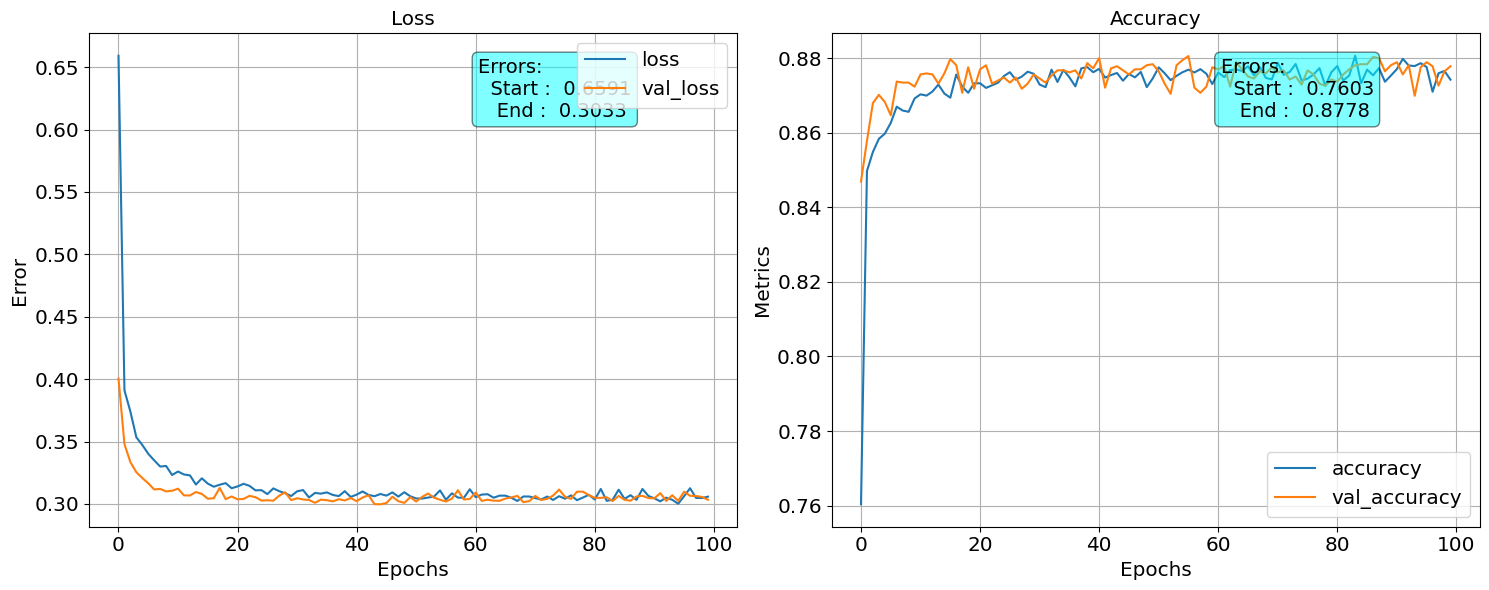

In [39]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

l_range = 50

ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot


# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title(y1.capitalize())
ax.grid();

ax = axes[1]

y1 = loss_df.columns[1]
y2 = loss_df.columns[3]
loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_title(y1.capitalize())
ax.grid();
plt.tight_layout()

In [41]:
loss_df[loss_df['val_loss']== loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
44,0.307956,0.873965,0.29971,0.876746


In [34]:
predict_model = model
predict_model.add(tf.keras.layers.Softmax(axis=1))
predict_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                612       
                                                                 
 batch_normalization (Batch  (None, 18)                72        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 18)                0         
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 76        
                                                                 
 softmax (Softmax)           (None, 4)                 0         
                                                        

NameError: name 'loss_hist' is not defined

In [ ]:
loss_df.head()

In [ ]:
model.summary()

In [ ]:
loss_df[loss_df['t_loss'] == loss_df['t_loss'].min()]

## Predictions
### Train Data
* Accuracy score on Train Data : 0.8965350967830819
* Accuracy score on Test Data : 0.8815426997245179

In [ ]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

### Test Data

In [ ]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();